<a href="https://colab.research.google.com/github/libreai/neural-painter-x/blob/master/notebooks/03_neural_painter_x_training_GAN_mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Joy of Neural Painting (3/4)

[Neural Painters](https://arxiv.org/abs/1904.08410) [1] are a class of models that can be seen as a fully differentiable simulation of a particular non-differentiable painting program, in other words, the machine "paints" by successively generating brushstrokes (i.e., actions that defines a brushstrokes) and applying them on a canvas, as an artist would do.

---

[1] *Neural Painters: A Learned Differentiable Constraint for Generating Brushstroke Paintings*. Reiichiro Nakano. arXiv preprint [arXiv:1904.08410](https://arxiv.org/abs/1904.08410), 2019.

# Transfer Learning for Adversarial Training (GAN mode) 

In this final stage, we continue the `Generator` and `Criti`c training in a GAN setting. The pre-trained `Generator` and `Critic` are already doing a descent work independently, *we transfer their knowledge*, in their respective tasks, and hook them up in a GAN setting to fine tune their their model weights.

<center><img src="https://raw.githubusercontent.com/libreai/neural-painter-x/master/images/neural_painter_generator_adversarial.jpg" width="80%"/></center>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as VF
import torch.optim as optim
import fastai
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import PIL
import os

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from glob import glob
from torchvision import models
from pathlib import Path
from IPython.display import display, clear_output

# from fastai.vision import *
from fastai.torch_core import requires_grad, children
from fastai.vision.gan import basic_generator, gan_critic
from fastai.callbacks import hook_outputs

print('torch.__version__', torch.__version__)


torch.__version__ 1.1.0


# Dataset

For the purposes of this excercise we will use a collection of 100K brushstrokes, that is a single `episodes` file from the full `neural-painters` dataset available in Kaggle: https://www.kaggle.com/reiinakano/mypaint_brushstrokes

We have made available a file using Google Drive: [episodes_2.npz](https://drive.google.com/a/libreai.com/uc?id=1KaXpNIwrdWPXVJmMXCR2YEoTW5BsDXzQ&export=download). Given its size (196M) `wget` or `curl` will fail because of the security warning from Google Drive, we will therefore go with [gdwon](https://pypi.org/project/gdown/) to download it. 

Note we are using a different file here than the one used for pre-training the `Generator` and `Critic`. 

In [0]:
!pip install gdown

In [0]:
# create a folder called `data` and donwload the dataset there
!mkdir data; cd data; gdown https://drive.google.com/uc?id=1KaXpNIwrdWPXVJmMXCR2YEoTW5BsDXzQ&export=download

Downloading...
From: https://drive.google.com/uc?id=1KaXpNIwrdWPXVJmMXCR2YEoTW5BsDXzQ
To: /content/data/episodes_2.npz
205MB [00:02, 99.2MB/s]


In [0]:
data_fname = 'episodes_2.npz'
loaded = np.load('data/' + data_fname)

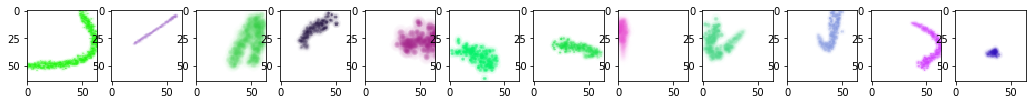

In [0]:
w=800
h=600

fig=plt.figure(figsize=(30, 10))
cols = 12

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

In [0]:
loaded['actions'][:cols]

array([[0.330522, 0.249296, 0.638134, 0.656268, ..., 0.38073 , 0.896127, 0.924754, 0.466711],
       [0.72314 , 0.260811, 0.776887, 0.059226, ..., 0.559846, 0.741848, 0.114233, 0.203668],
       [0.992721, 0.830709, 0.019449, 0.30396 , ..., 0.821641, 0.674657, 0.922126, 0.893378],
       [0.174172, 0.807182, 0.734837, 0.432679, ..., 0.718031, 0.459332, 0.69727 , 0.848882],
       ...,
       [0.234808, 0.834783, 0.7658  , 0.520075, ..., 0.341833, 0.937458, 0.986008, 0.497608],
       [0.295077, 0.680203, 0.709675, 0.272433, ..., 0.458307, 0.830108, 0.251563, 0.731567],
       [0.227581, 0.703463, 0.452308, 0.504263, ..., 0.88884 , 0.30347 , 0.054811, 0.541374],
       [0.41137 , 0.667527, 0.380177, 0.360587, ..., 0.664123, 0.001316, 0.249934, 0.20228 ]])

# Building Blocks

In [0]:
class Params():
    def __init__(self):
        super(Params)

In [0]:
params = Params()

params.condition_dim = 12
params.noise_dim = 0
params.image_size = 64
params.channels = 3
params.batch_size = 256
#params.lr = 1e-3
params.lr = 1e-4
params.train_epochs = 1
params.fc_dim = int(params.image_size * params.image_size)


## The Generator

The `Generator` is defined as a `[Linear Layer](https://pytorch.org/docs/stable/nn.html#linear)` followed by a [`Deep Convolutional Neural Network`](https://docs.fast.ai/vision.gan.html#basic_generator)

In [0]:
class GeneratorX(nn.Module):

    def __init__(self, condition_dim, fc_dim, in_size, n_channels, n_extra_layers):
        super(GeneratorX, self).__init__()
        self.fc = nn.Linear(condition_dim, fc_dim)
        self.generator = basic_generator(in_size=in_size, n_channels=n_channels, n_extra_layers=n_extra_layers, noise_sz=fc_dim)

    def forward(self, x):
        x = self.fc(x)
        x = self.generator(x.view(x.size(0), x.size(1), 1, 1))
        return x



In [0]:
generator = GeneratorX(condition_dim=params.condition_dim,
                fc_dim=params.fc_dim,
                in_size=params.image_size,
                n_channels=params.channels,
                n_extra_layers=1
               )

generator

GeneratorX(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, 

## The Critic

In [0]:
critic = gan_critic(nf=64)
critic

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Dropout2d(p=0.075)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (2): MergeLayer()
    )
  )
  (3): Dropout2d(p=0.15)
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): SelfAttention(
      (query): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (key): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (value): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False

## The Feature Loss

Using a VGG16 model as Feature Extractor

In [0]:
vgg_m = models.vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:25<00:00, 21305401.95it/s]


[5, 12, 22, 32, 42]

Feature Loss based on the implementation introduced in 

* Fast.ai MOOC [Lesson 7: Resnets from scratch; U-net; Generative (adversarial) networks.](https://course.fast.ai/videos/?lesson=7). 

This loss is a variant of `Perceptual Losses` discussed in the paper:

* *Perceptual Losses for Real-Time Style Transfer and Super-Resolution*. Justin Johnson, Alexandre Alahi, Li Fei-Fei. https://arxiv.org/abs/1603.08155 , 2016

In [0]:
def gram_matrix(x):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features @ features_t / (ch * h * w)
    return gram
  


In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, feature_extractor, layer_ids, layer_wgts):
        super(FeatureLoss, self).__init__()
        
        # using L1 as base for computing the loss
        self.base_loss = F.l1_loss 
        self.feature_extractor = feature_extractor
        self.loss_features = [self.feature_extractor[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts

    def make_features(self, x, clone=False):
        self.feature_extractor(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):

        input_features = self.make_features(input)
        target_features = self.make_features(target, clone=True)
        
        self.feat_losses = []
        
        self.feat_losses += [self.base_loss(f_in, f_out) * w
                             for f_in, f_out, w in zip(input_features, target_features, self.wgts)]
        

        self.feat_losses += [self.base_loss(gram_matrix(f_in), gram_matrix(f_out)) * w**2 * 5e3
                             for f_in, f_out, w in zip(input_features, target_features, self.wgts)]
    
        self.feat_losses += [self.base_loss(input, target)]
                
        return sum(self.feat_losses)
    
    def __del__(self):
        self.hooks.remove()
        

---

## Adversarial Training (GAN mode) 

At this stage we have a `generator` and `critic` trained independently. The idea is now to trained them GAN-style in an adversarial fashion to refine the quality to the strokes the `generator` produces.

Let's load the pre-trained `Generator` and `Critic`.

In [0]:
# In case you don't have your `Generator` and `Critic` from the previous steps, you can
# dowload the ones we trained uncommenting the following lines:
# !mkdir models
# !cd models; gdown https://drive.google.com/uc?id=1knOYFm-PBk0ovwPoVjV5ivc6-ts-8eHG
# !cd models; gdown https://drive.google.com/uc?id=1wC0ewdNGHVC8QUsp8M7mVPZANsjTGg2s

Downloading...
From: https://drive.google.com/uc?id=1knOYFm-PBk0ovwPoVjV5ivc6-ts-8eHG
To: /content/models/neural_painter_x_non_adversarial_generator_param.pth
146MB [00:01, 87.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wC0ewdNGHVC8QUsp8M7mVPZANsjTGg2s
To: /content/models/neural_painter_x_non_adversarial_critic_param.pth
44.9MB [00:01, 44.1MB/s]


In [0]:
! ls ./models

neural_painter_x_non_adversarial_critic_param.pth
neural_painter_x_non_adversarial_generator_param.pth


In [0]:
models_base_path = './models/'

In [0]:
# Load the pre-trained Generator parameters
gen_path = 'neural_painter_x_non_adversarial_generator_param.pth'
generator.load_state_dict(torch.load(models_base_path + gen_path))
generator.cuda()

# Adam optimizer
gen_optimizer = optim.Adam(generator.parameters(), lr=params.lr, betas=(0.5, 0.9))

In [0]:
# Load the pre-trained Critic parameters

critic_path = 'neural_painter_x_non_adversarial_critic_param.pth'
critic.load_state_dict(torch.load(models_base_path + critic_path))
critic.cuda()

# Adam optimizer
critic_optimizer = optim.Adam(critic.parameters(), lr=params.lr, betas=(0.5, 0.9))

In [0]:
# The loss functions

bce_loss = torch.nn.functional.binary_cross_entropy
feature_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [0]:
strokes = loaded['strokes']
conditions = loaded['actions']

strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div_(255))
                                  ])

strokes = torch.stack([torch.from_numpy(s).permute(2, 0, 1) for s in strokes])
conditions = torch.stack([torch.from_numpy(c).float() for c in conditions])

dataset = TensorDataset(strokes, conditions)
dataloader = DataLoader(dataset, batch_size=params.batch_size, shuffle=False)

training start!
epoch 1/1 | 1/391 complete!
critic loss: 0.2502670884132385
generator loss: 3.0008692741394043
true
critic pred: 0.9999898672103882 (true=1)
torch.Size([3, 64, 64])


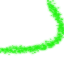

pred
critic pred: 0.001885963836684823 (true=0)
torch.Size([3, 64, 64])


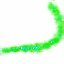

---
epoch 1/1 | 26/391 complete!
critic loss: 0.5253387093544006
generator loss: 1.818426251411438
true
critic pred: 0.5630504488945007 (true=1)
torch.Size([3, 64, 64])


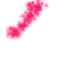

pred
critic pred: 0.3330579102039337 (true=0)
torch.Size([3, 64, 64])


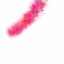

---
epoch 1/1 | 51/391 complete!
critic loss: 0.6057736873626709
generator loss: 1.4319829940795898
true
critic pred: 0.5302298665046692 (true=1)
torch.Size([3, 64, 64])


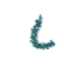

pred
critic pred: 0.48086392879486084 (true=0)
torch.Size([3, 64, 64])


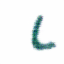

---
epoch 1/1 | 76/391 complete!
critic loss: 0.6332395672798157
generator loss: 1.285575270652771
true
critic pred: 0.504852294921875 (true=1)
torch.Size([3, 64, 64])


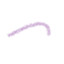

pred
critic pred: 0.5106377601623535 (true=0)
torch.Size([3, 64, 64])


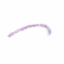

---
epoch 1/1 | 101/391 complete!
critic loss: 0.6497037410736084
generator loss: 1.20392906665802
true
critic pred: 0.4989301264286041 (true=1)
torch.Size([3, 64, 64])


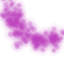

pred
critic pred: 0.46989643573760986 (true=0)
torch.Size([3, 64, 64])


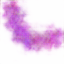

---
epoch 1/1 | 126/391 complete!
critic loss: 0.6594478487968445
generator loss: 1.151970386505127
true
critic pred: 0.5115633606910706 (true=1)
torch.Size([3, 64, 64])


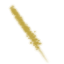

pred
critic pred: 0.4735743999481201 (true=0)
torch.Size([3, 64, 64])


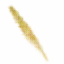

---
epoch 1/1 | 151/391 complete!
critic loss: 0.6652382612228394
generator loss: 1.1153452396392822
true
critic pred: 0.4848249554634094 (true=1)
torch.Size([3, 64, 64])


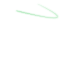

pred
critic pred: 0.4662722051143646 (true=0)
torch.Size([3, 64, 64])


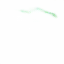

---
epoch 1/1 | 176/391 complete!
critic loss: 0.668915867805481
generator loss: 1.0892220735549927
true
critic pred: 0.5197975039482117 (true=1)
torch.Size([3, 64, 64])


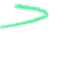

pred
critic pred: 0.47060924768447876 (true=0)
torch.Size([3, 64, 64])


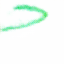

---
epoch 1/1 | 201/391 complete!
critic loss: 0.6716096997261047
generator loss: 1.0694748163223267
true
critic pred: 0.5389976501464844 (true=1)
torch.Size([3, 64, 64])


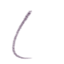

pred
critic pred: 0.4719209372997284 (true=0)
torch.Size([3, 64, 64])


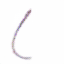

---
epoch 1/1 | 226/391 complete!
critic loss: 0.6739412546157837
generator loss: 1.0541492700576782
true
critic pred: 0.48447638750076294 (true=1)
torch.Size([3, 64, 64])


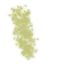

pred
critic pred: 0.4831012189388275 (true=0)
torch.Size([3, 64, 64])


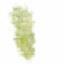

---
epoch 1/1 | 251/391 complete!
critic loss: 0.6756101250648499
generator loss: 1.0417890548706055
true
critic pred: 0.48672646284103394 (true=1)
torch.Size([3, 64, 64])


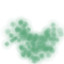

pred
critic pred: 0.4700457751750946 (true=0)
torch.Size([3, 64, 64])


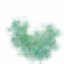

---
epoch 1/1 | 276/391 complete!
critic loss: 0.6768521070480347
generator loss: 1.0314750671386719
true
critic pred: 0.5030110478401184 (true=1)
torch.Size([3, 64, 64])


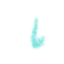

pred
critic pred: 0.48979270458221436 (true=0)
torch.Size([3, 64, 64])


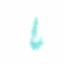

---
epoch 1/1 | 301/391 complete!
critic loss: 0.6780350208282471
generator loss: 1.0229437351226807
true
critic pred: 0.4961121082305908 (true=1)
torch.Size([3, 64, 64])


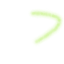

pred
critic pred: 0.508658230304718 (true=0)
torch.Size([3, 64, 64])


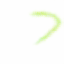

---
epoch 1/1 | 326/391 complete!
critic loss: 0.6788769960403442
generator loss: 1.015815258026123
true
critic pred: 0.5237158536911011 (true=1)
torch.Size([3, 64, 64])


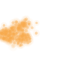

pred
critic pred: 0.5257101058959961 (true=0)
torch.Size([3, 64, 64])


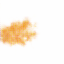

---
epoch 1/1 | 351/391 complete!
critic loss: 0.6796138286590576
generator loss: 1.0096464157104492
true
critic pred: 0.5042465925216675 (true=1)
torch.Size([3, 64, 64])


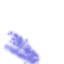

pred
critic pred: 0.5062639117240906 (true=0)
torch.Size([3, 64, 64])


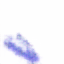

---
epoch 1/1 | 376/391 complete!
critic loss: 0.6802111268043518
generator loss: 1.0041313171386719
true
critic pred: 0.46527382731437683 (true=1)
torch.Size([3, 64, 64])


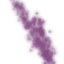

pred
critic pred: 0.4909825623035431 (true=0)
torch.Size([3, 64, 64])


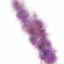

---
[1/1] - ptime: 1816.69, loss: nan
Saving Generator and Critic
done


In [0]:
# results save folder
root = './models/'
model = 'neuro_painter_x_'

if not os.path.isdir(root):
    os.mkdir(root)
    
critic_losses = []
generator_losses = []

print('training start!')
start_time = time.time()

for epoch in range(params.train_epochs):
  epoch_start_time = time.time()

  for num_iter, (stroke, condition) in enumerate(dataloader):  
    condition = condition.cuda()
    stroke = torch.stack([strokes_tfms(s) for s in stroke]).cuda()

    batch_size = stroke.shape[0]

    # ground truths
    
    valid = torch.ones((batch_size, 1), dtype=torch.float, requires_grad=False).cuda()
    
    fake = torch.zeros((batch_size, 1), dtype=torch.float, requires_grad=False).cuda()

    # -----------------
    #  Train Critic
    # -----------------
    critic_optimizer.zero_grad()

    # computing the loss for true strokes
    critic_true_preds = torch.sigmoid(critic(stroke))
    critic_true_loss = bce_loss(critic_true_preds, valid)

    # computing the loss for generated (aka fake) strokes
    generated_stroke = generator(condition)
    critic_fake_preds = torch.sigmoid(critic(generated_stroke))
    critic_fake_loss = bce_loss(critic_fake_preds, fake)

    # taking the tarain loss as the average
    critic_train_loss = (critic_true_loss + critic_fake_loss) / 2.

    critic_train_loss.backward()
    critic_optimizer.step()

    critic_losses.append(critic_train_loss.data.item())

    # -----------------
    #  Train Generator
    # -----------------

    gen_optimizer.zero_grad()

    generated_stroke = generator(condition)
    critic_preds = torch.sigmoid(critic(generated_stroke))

    gen_train_loss = (bce_loss(critic_preds, valid) + feature_loss(generated_stroke, stroke)) / 2

    gen_train_loss.backward()
    gen_optimizer.step()

    generator_losses.append(gen_train_loss.data.item())


    if (num_iter % 25) == 0:
        print('epoch {}/{} | {}/{} complete!'.format((epoch + 1), 
                                                     (params.train_epochs),
                                                     (num_iter+1), 
                                                     len(dataloader)))
        print('critic loss: {}'.format(torch.mean(torch.FloatTensor(critic_losses)).item()))
        print('generator loss: {}'.format(torch.mean(torch.FloatTensor(generator_losses)).item()))
        # ---
        s = stroke[0].clone().cpu()
        print('true')
        print('critic pred:', critic_true_preds[0].item(), '(true=1)')
        display(VF.to_pil_image(s))
        print('---')
        g = generated_stroke[0].clone().cpu()
        print('pred')
        print('critic pred:', critic_preds[0].item(), '(true=0)')
        display(VF.to_pil_image(g))
        print('---')

  epoch_end_time = time.time()
  per_epoch_ptime = epoch_end_time - epoch_start_time

  print('[%d/%d] - ptime: %.2f, generator loss: %.3f' % ((epoch + 1),
                                               params.train_epochs,
                                               per_epoch_ptime,
                                               torch.mean(torch.FloatTensor(generator_losses)).item()))


print('Saving Generator and Critic')
torch.save(critic.state_dict(), root + model + 'final' + '_GAN_critic_param.pth')      
torch.save(generator.state_dict(), root + model + 'final' + '_GAN_generator_param.pth')      
print('done')

In [0]:
! ls ./models

neural_painter_x_non_adversarial_critic_param.pth
neural_painter_x_non_adversarial_generator_param.pth
neuro_painter_x_final_GAN_critic_param.pth
neuro_painter_x_final_GAN_generator_param.pth


A single epoch fine-tuning the `Generator` and `Critic` helps improving the quality of the brushstrokes. You can try training over a couple of more epochs and monitor how the generated brushstrokes evolve. 

Now we are ready to paint :)

# ~ fin ~